In [1]:
!date
import numpy as np, pandas as pd, pymc as pm, matplotlib.pyplot as plt, dismod_mr
%matplotlib inline

Thu Nov  9 19:12:20 PST 2017


# Update of Depression in Conflict

Estimates for Fiona Charlson to present to WHO on October 6, 2017.

The data dictionary and covariates to be included are in separate tabs with the file but I have also listed them below. Hopefully there are not too many spurious errors that DisMod doesn’t like, but if there are just let me know and I’ll make fixes.

Thanks so much Abie. I’ll be taking these final estimates to Geneva with me on 6 October. Very curious to see how they may have changed!

## Depression

* •	Time_since_conflict
* •	Super_region
* •	Symptom scale_coded

### Based on Depression Model from [2015](/notebooks/2015/2015_05_19b_MDD_Conflict.ipynb)

In [2]:
np.random.seed(12345)

In [3]:
mdd = dismod_mr.data.load('/home/j/Project/dismod/output/dm-40553')
df = pd.io.excel.read_excel('data/Anxiety_Dataset_230917.xlsx', 'Depression data cleaned')

/snfs2/HOME/abie/projects/2016/dismod_mr/dismod_mr/data.py:595: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  d.output_template = pd.DataFrame.from_csv(path + '/output_template.csv')


In [4]:
dm = dismod_mr.data.ModelData()

inp = pd.DataFrame(columns=dm.input_data.columns, index=df.index)

# data type, value, and uncertainty
inp.data_type = 'p'
inp.value = df.Parameter_value / df.Units
inp.effective_sample_size = df.Denominator

# geographic information (to be used for random effects)
#inp.area = df.Country
inp.area = df.Super_region.astype(str)

inp.sex = df.Sex.map({'Male':'male', 'Female':'female', 'Total':'total'})
inp.age_start = df.Age_start
inp.age_end = df.Age_end

inp.standard_error = np.nan
inp.upper_ci = np.nan
inp.lower_ci = np.nan

# setup model
dm.parameters['p'] = mdd.parameters['p'].copy()
dm.set_decreasing('p', 85, 101)
for i, row in df.iterrows():  # FIXME: cast-to-string currently need, unicode strings fail
    dm.hierarchy.add_edge('all', str(row['Super_region']))
    #dm.hierarchy.add_edge(str(row['Super_region']), str(row['GBD_region']))
    #dm.hierarchy.add_edge(str(row['GBD_region']), str(row['Country']))

In [5]:
def float_or_nan(x):
    try:
        return float(x)
    except ValueError:
        return np.nan
    
assert float_or_nan(1) == 1
assert np.isnan(float_or_nan('-'))

In [6]:
# super-region added above

# coverage
#inp['x_coverage_1'] = df.Coverage_coded==1
#inp['x_coverage_2'] = df.Coverage_coded==2

# # diagnostic interview
# inp['x_clinical_dx_1'] = df.Clinician_diagnosis_CODED == 1
inp['x_symptom_scale'] = df['Symptom scale_coded']

# response rate
inp['x_response_rate_1_or_2'] = df['Response _rate_coded'] >= 1
inp['x_response_rate_missing'] = df['Response _rate_coded'].isnull()

# sex included above

# parameter type
#inp['x_param_type_coded_1'] = df.Parameter_type_coded==1
#inp['x_param_type_coded_2'] = df.Parameter_type_coded==2

# time since conflict categorical vars
for i in [5,4,3,2]:
    col = 'x_tsc_%d'%i
    inp[col] = df.Time_since_conflict==i

# # how to code length of conflict?
# inp['x_length_of_conflict_geq_10'] = df.Length_of_conflict.map(float_or_nan) >= 10
# inp['x_length_of_conflict_geq_1'] = df.Length_of_conflict.map(float_or_nan) >= 1

# war-related events ratio
#inp['x_war_related_events_ratio_geq_.3'] = df.Warrelated_events_ratio.fillna(0) >= .3
#inp['x_war_related_events_ratio_missing'] = df.Warrelated_events_ratio.isnull()

# population description coded
inp['x_pop_descr_coded_1'] = df.Population_description_coded==1
inp['x_pop_descr_coded_2'] = df.Population_description_coded==2


In [7]:
inp.iloc[0]

data_type                       p
value                      0.5873
area                            6
sex                        female
age_start                      18
age_end                        85
year_start                    NaN
year_end                      NaN
standard_error                NaN
effective_sample_size        1242
lower_ci                      NaN
upper_ci                      NaN
age_weights                   NaN
x_symptom_scale                 1
x_response_rate_1_or_2      False
x_response_rate_missing     False
x_tsc_5                     False
x_tsc_4                     False
x_tsc_3                     False
x_tsc_2                     False
x_pop_descr_coded_1         False
x_pop_descr_coded_2         False
Name: 0, dtype: object

In [8]:
# add additional data rows to obtain output estimates for requested age groups
ages = [[0,10],
        [10,20],
        [20,30],
        [30,40],
        [40,50],
        [50,60],
        [60,70],
        [70,80]]
for age_start, age_end in ages:
    inp = inp.append(pd.Series({'data_type':'p',
                                'value': 0,
                                'effective_sample_size':0,
                                'area': 'all',
                                'sex': 'total',
                                'age_start': age_start,
                                'age_end': age_end,
'x_symptom_scale':                 0,
'x_response_rate_1_or_2':      False,
'x_response_rate_missing':     False,
'x_tsc_5':                     False,
'x_tsc_4':                     False,
'x_tsc_3':                     False,
'x_tsc_2':                     False,
'x_pop_descr_coded_1':         False,
'x_pop_descr_coded_2':         False,
                                }), ignore_index=True)

In [9]:
dm.input_data = inp.copy()

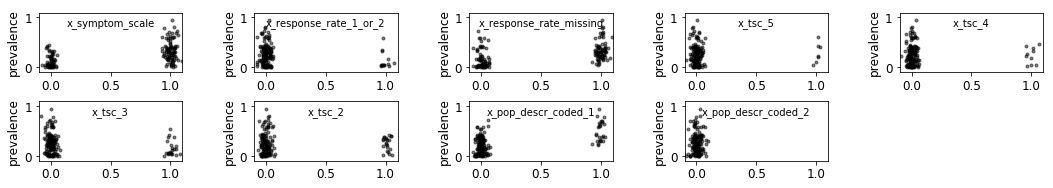

In [10]:
# set mpl defaults for nice display
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['lines.linewidth'] = 1
    
X = inp.filter(like='x_')
y = inp.value
for i, c_i in enumerate(X.columns):
    plt.subplot(4,5,1+i)
    plt.title('\n'+c_i, va='top', fontsize=10)
    plt.ylabel('prevalence')
    plt.plot(X[c_i]+np.random.normal(size=len(y))*.03, y, 'k.', alpha=.5)
    plt.axis(xmin=-.1, xmax=1.1, ymin=-.1, ymax=1.1)
    plt.subplots_adjust(hspace=.5, wspace=.5)

In [11]:
inp.x_pop_descr_coded_2.sum()

0

In [12]:
#dm.set_knots('p', [0, 2, 4, 6, 8, 10, 25, 55, 100])
#dm.set_knots('p', [0,3,10,20,30,45,55,70,85,100])
dm.set_knots('p', [0,2,4,6,8,10,20,30,45,55,70,85])
dm.set_decreasing('p', 100, 100)
dm.parameters['ages'] = range(0,86)

In [13]:
dm.parameters['p']

{'decreasing': {'age_end': 100, 'age_start': 100},
 'fixed_effects': {},
 'heterogeneity': 'Very',
 'increasing': {'age_end': 0, 'age_start': 0},
 'level_bounds': {'lower': 0.0, 'upper': 1.0},
 'level_value': {'age_after': 100, 'age_before': 3, 'value': '0.0'},
 'parameter_age_mesh': [0, 2, 4, 6, 8, 10, 20, 30, 45, 55, 70, 85],
 'random_effects': {},
 'smoothness': {'age_end': 100, 'age_start': 0, 'amount': 'Slightly'},
 'y_maximum': 1.0}

In [14]:
dm.setup_model(rate_type='p', rate_model='neg_binom')

/snfs2/HOME/abie/projects/2016/dismod_mr/dismod_mr/model/covariates.py:84: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: (U[col].max() > 0) and (model.hierarchy.node[col].get('level') > model.hierarchy.node[root_area]['level']), axis=1)  # drop columns with only zeros and which are for higher levels in hierarchy
/snfs2/HOME/abie/projects/2016/dismod_mr/dismod_mr/model/covariates.py:98: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: 1 <= U[col].sum() < len(U[col]) or col in keep, axis=1)
/snfs2/HOME/abie/projects/2016/dismod_mr/dismod_mr/model/covariates.py:187: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  X = input_data.select(lambda col: col.startswith('x_'), axis=1)
/snfs2/HOME/

In [ ]:
def invalid_precision(dm):
    return dm.input_data.effective_sample_size.isnull() \
      & dm.input_data.standard_error.isnull() \
      & (dm.input_data.lower_ci.isnull() | dm.input_data.upper_ci.isnull())
dm.input_data[invalid_precision(dm)].iloc[:,:10]

,data_type,value,area,sex,age_start,age_end,year_start,year_end,standard_error,effective_sample_size
137,p,0.0261,4,male,24,33,NaN,NaN,NaN,NaN
138,p,0.0344,4,female,24,33,NaN,NaN,NaN,NaN
139,p,0.0399,4,total,24,33,NaN,NaN,NaN,NaN
140,p,0.3830,6,male,18,85,NaN,NaN,NaN,NaN


In [ ]:
%time dm.fit(how='mcmc', iter=1000000, burn=500000, thin=500)

finding initial values
.
.
.

finding MAP estimate

finding step covariances estimate

resetting initial values (1)
.
.
.

resetting initial values (2)

mare: 0.36
sampling from posterior



In [22]:
from matplotlib.pylab import *

In [23]:
import dismod_mr
import importlib
importlib.reload(dismod_mr.plot)

<module 'dismod_mr.plot' from '/snfs2/HOME/abie/projects/2016/dismod_mr/dismod_mr/plot.py'>

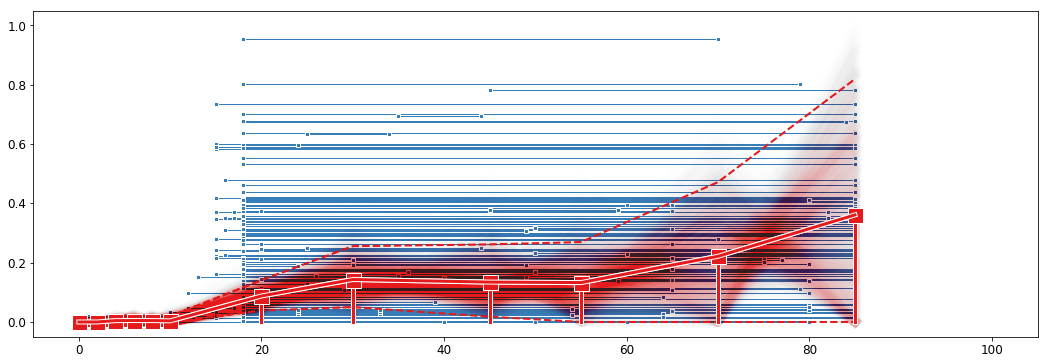

In [24]:
def plot(self, rate_type=None):
    import matplotlib.pyplot as plt, numpy as np
    import dismod_mr.plot as plot

    if rate_type or 'rate_type' in self.model_settings:
        plot_types = self.model_settings.get('rate_type', rate_type)
    else:
        plot_types = ['p', 'i', 'r', 'f']

    fig = plt.figure()

    for i, t in enumerate(plot_types):
        if len(plot_types) == 4:
            plt.subplot(2, 2, i+1)
            plt.title(t)
            plt.subplots_adjust(hspace=.5, wspace=.4)

        a0 = self.parameters['ages'][0]

        plot.data_bars(self.get_data(t), color=plot.colors[1])

        if t in self.vars:
            x = np.array(self.parameters['ages'])
            knots = self.vars[t].get('knots', np.array([]))

            if not hasattr(self.vars[t]['mu_age'], 'trace'):
                pt = self.vars[t]['mu_age'].value
                plt.plot(x, pt, linewidth=3, color=plot.colors[0])
                if len(knots) > 0:
                    plt.plot(knots, pt[knots-a0], 's', ms=15, mec='w', color=plot.colors[0])
            else:

                pred = self.vars[t]['mu_age'].trace()
                import pymc as mc
                ui =mc.utils.hpd(pred, .05)

                if len(knots) > 0:
                    plt.plot(x[knots-a0], ui[:, knots-a0].T, '--', linewidth=2, color=plot.colors[0], alpha=1)
                else:
                    plt.plot(x, ui, '--', linewidth=2, color=plot.colors[0], alpha=1)

                plt.plot(x, pred.T, linewidth=10, color=plot.colors[0], alpha=.005)
                plt.plot(self.parameters['ages'], pred.mean(0), linewidth=5, color='w')

                if len(knots) > 0:
                    xx = []
                    yy = []
                    for k_i in knots:
                        xx += [k_i, k_i, np.nan]
                        yy += [0., pred.mean(axis=0)[k_i-a0], np.nan]
                    plt.plot(xx, yy, linewidth=5, color='w')
                    plt.plot(xx, yy, linewidth=3, color=plot.colors[0])
                    plt.plot(self.parameters['ages'], pred.mean(0), linewidth=3, color=plot.colors[0])
                    plt.plot(knots, pred.mean(axis=0)[knots-a0], 's', ms=15, mec='w', color=plot.colors[0])

                import pymc as mc
                ui =mc.utils.hpd(pred, .05)
                plt.plot(x, pred.mean(0), linewidth=5, color='w')
                plt.plot(x, pred.mean(0), linewidth=3, color=plot.colors[0])

        plt.axis(xmin=-5, xmax=105)


plot(dm)
plt.savefig('mdd_conflict_age.png')
#dismod_mr.plot.effects(dm, 'p', figsize=(18,12))
#plt.savefig('mdd_conflict_effects.png')

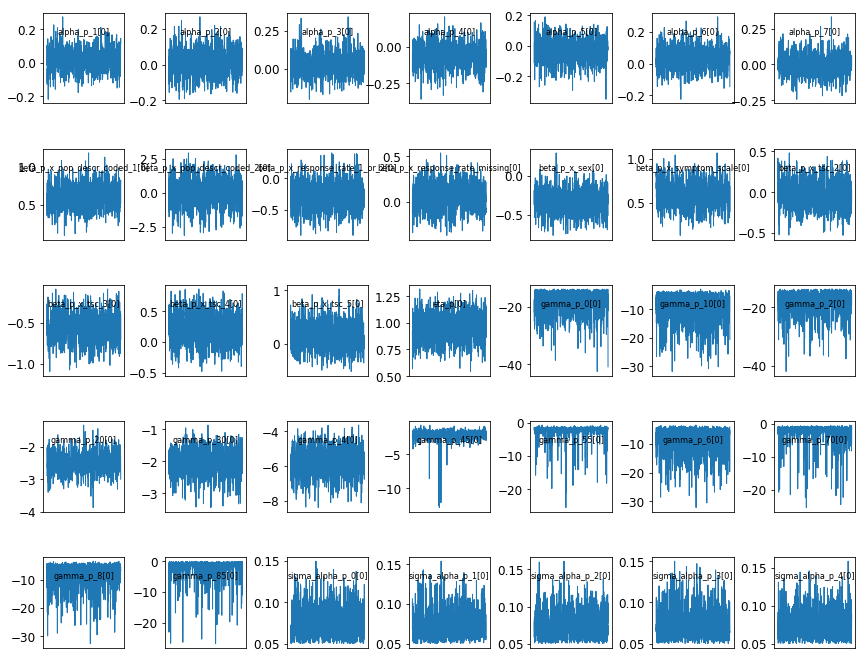

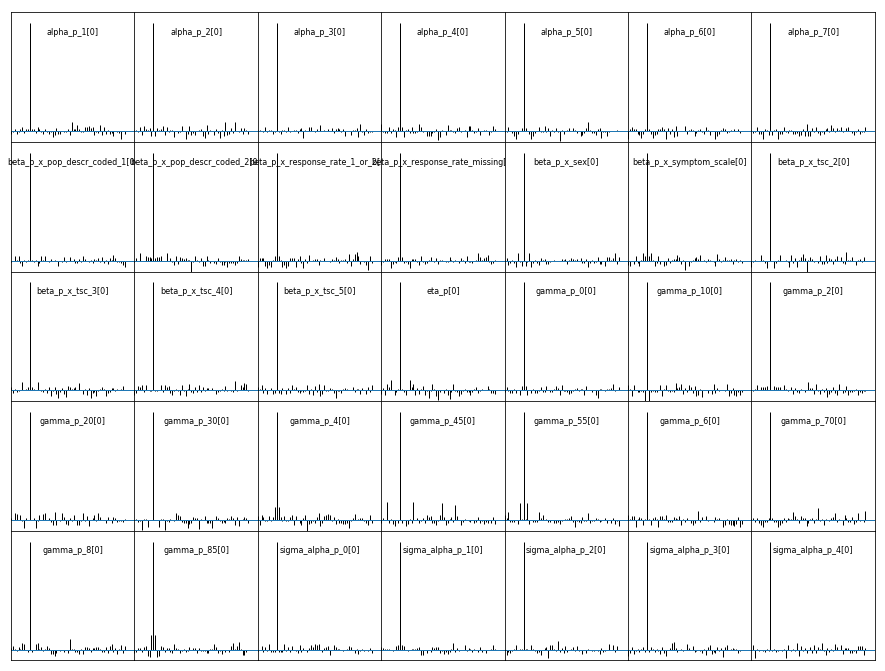

In [25]:

def plot_trace(model):
    def show_trace(trace):
        plt.plot(trace)
        plt.xticks([])

    plot_viz_of_stochs(model.vars, show_trace, (12,9))
    plt.subplots_adjust(.05,.01,.99,.99,.5,.5)

def plot_acorr(model):
    from matplotlib import mlab
    def acorr(trace):
        if len(trace) > 50:
            plt.acorr(trace, normed=True, detrend=mlab.detrend_mean, maxlags=50)
        plt.xticks([])
        plt.yticks([])
        l,r,b,t = plt.axis()
        plt.axis([-10, r, -.1, 1.1])

    plot_viz_of_stochs(model.vars, acorr, (12,9))
    plt.subplots_adjust(0,0,1,1,0,0)


def plot_viz_of_stochs(vars, viz_func, figsize=(8,6)):
    """ Plot autocorrelation for all stochs in a dict or dict of dicts

    :Parameters:
      - `vars` : dictionary
      - `viz_func` : visualazation function such as ``acorr``, ``show_trace``, or ``hist``
      - `figsize` : tuple, size of figure

    """
    plt.figure(figsize=figsize)

    cells, stochs = dismod_mr.plot.tally_stochs(vars)

    # for each stoch, make an autocorrelation plot for each dimension
    rows = np.floor(np.sqrt(cells))
    cols = np.ceil(cells/rows)

    tile = 1
    for s in sorted(stochs, key=lambda s: s.__name__):
        trace = s.trace()
        if len(trace.shape) == 1:
            trace = trace.reshape((len(trace), 1))
        for d in range(len(np.atleast_1d(s.value))):
            plt.subplot(rows, cols, tile)
            viz_func(np.atleast_2d(trace)[:, d])
            plt.title('\n\n%s[%d]'%(s.__name__, d), va='top', ha='center', fontsize=8)
            tile += 1

plot_trace(dm)
plot_acorr(dm)

[-5, 105, -0.32690863613660875, 0.86560830541925804]

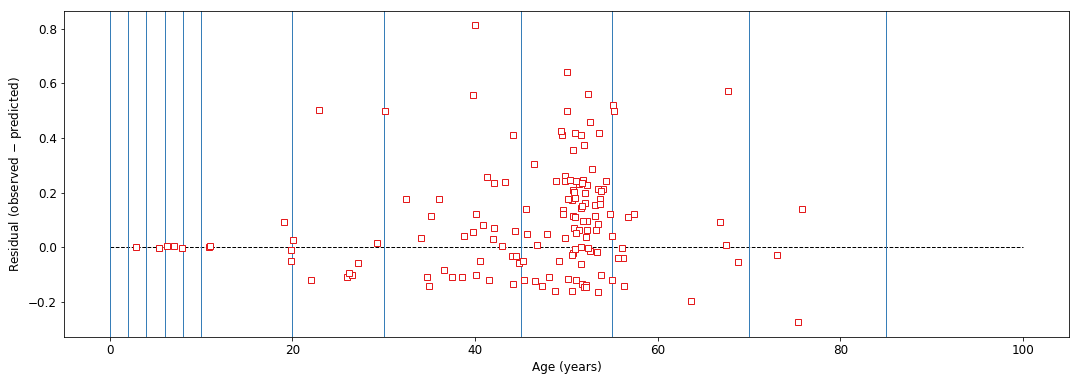

In [26]:
inp = dm.input_data
plt.plot((inp.age_start+inp.age_end)/2 + 2*np.random.randn(len(inp.index)),
     inp.value - dm.vars['p']['mu_interval'].trace().mean(axis=0), 's',
        mec=dismod_mr.plot.colors[0], mew=1, color='w')
hlines([0],0,100, linestyle='dashed')
xlabel('Age (years)')
ylabel('Residual (observed $-$ predicted)')
l,r,b,t = axis()
vlines(dm.parameters['p']['parameter_age_mesh'],-1,1, linestyle='solid', color=dismod_mr.plot.colors[1])
axis([-5,105,b,t])


In [27]:
dm.vars['p']['mu_interval'].trace().mean(axis=0).shape

(149,)

In [28]:
countries = list(dm.input_data.area.unique())

dm.output_template = pd.DataFrame(dict(area=countries+countries,
                                       sex=['male']*len(countries) + ['female']*len(countries)))

for cov in dm.input_data.filter(like='x_'):
    dm.output_template[cov] = 0.

# FIXME: need to fill in correct UN_HDI value for given country/year
#dm.output_template['x_UN_HDI'] = df.UN_HDI.max()


dm.output_template['pop'] = 1  # pop is important for aggregating multiple areal units, but not relevant for this case
dm.output_template['year'] = 'all'

dm.output_template['x_sex'] = dm.output_template.sex.map({'male':.5, 'female':-.5})

In [29]:
import pymc as mc
#figure()
#plot(arange(101),
#     dm.predict_for('Iraq', 'female', 'all').mean(0), 'k-')
#plot(arange(101),
#     mc.utils.hpd(dm.predict_for('Iraq', 'female', 'all'), .05), 'k--');

In [30]:
!date

Fri Nov 10 14:48:29 PST 2017


In [31]:
def stats(self, alpha=0.05, start=0, batches=100,
          chain=None, quantiles=(2.5, 25, 50, 75, 97.5)):
    trace = self.trace()

    n = len(trace)
    if not n:
        print_(
            'Cannot generate statistics for zero-length trace in',
            self.__name__)
        return

    return {
        'n': n,
        'standard deviation': trace.std(0),
        'mean': trace.mean(0),
        '%s%s HPD interval' % (int(100 * (1 - alpha)), '%'): pm.utils.hpd(trace, alpha),
        #'mc error': batchsd(trace, min(n, batches)),
        #'quantiles': utils.quantiles(trace, qlist=quantiles)
    }


In [32]:
t = pd.DataFrame([stats(s) for s in dm.vars['p']['alpha']])
t.index = [s.__name__ for s in dm.vars['p']['alpha']]
t.to_csv('mdd_conflict_re.csv')

In [33]:
t = pd.DataFrame([stats(s) for s in dm.vars['p']['beta']])
t.index = [s.__name__ for s in dm.vars['p']['beta']]
t.to_csv('mdd_conflict_fe.csv')

In [34]:
t

,95% HPD interval,mean,n,standard deviation
beta_p_x_symptom_scale,"[0.324901884056, 0.879517926599]",0.594791,1000,0.141747
beta_p_x_response_rate_1_or_2,"[-0.671755526822, 0.153290951908]",-0.292657,1000,0.217618
beta_p_x_response_rate_missing,"[-0.213000819713, 0.348472163412]",0.064042,1000,0.146424
beta_p_x_tsc_5,"[-0.363444510392, 0.593862887938]",0.125153,1000,0.253952
beta_p_x_tsc_4,"[-0.295499813954, 0.639710825931]",0.185109,1000,0.238689
beta_p_x_tsc_3,"[-0.91069345916, -0.251826081805]",-0.571979,1000,0.166572
beta_p_x_tsc_2,"[-0.355342025246, 0.285170369433]",-0.032174,1000,0.167749
beta_p_x_pop_descr_coded_1,"[0.319911677049, 0.925304191581]",0.614098,1000,0.155610
beta_p_x_pop_descr_coded_2,"[-1.86484121516, 2.09370915455]",-0.019981,1000,0.990492
beta_p_x_sex,"[-0.623595488577, -0.0271812810083]",-0.333203,1000,0.152592


In [35]:
importlib.reload(pm)

<module 'pymc' from '/homes/abie/miniconda3/lib/python3.6/site-packages/pymc/__init__.py'>

In [36]:
s = stats(dm.vars['p']['mu_age'])

t = pd.DataFrame(dict(mean=s['mean'],
                      lb=s['95% HPD interval'].T[:,0],
                      ub=s['95% HPD interval'].T[:,1]),
                 index=dm.parameters['ages'],
                 columns=['mean', 'lb', 'ub'])

t.to_csv('mdd_conflict_age.csv')

In [37]:
# Use mu_age as reference value prediction
pred_ref = dm.vars['p']['mu_age'].trace()

pred_ref.shape

(1000, 86)

In [38]:
dm.vars['p']['beta']

[<pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_symptom_scale' at 0x7fe0fe33ca20>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_response_rate_1_or_2' at 0x7fe0fe33c4a8>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_response_rate_missing' at 0x7fe0fe4ac3c8>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_tsc_5' at 0x7fe0fe4ac9b0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_tsc_4' at 0x7fe0fe4ac630>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_tsc_3' at 0x7fe0fe4ac470>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_tsc_2' at 0x7fe0fe4ac588>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_pop_descr_coded_1' at 0x7fe0fe4acba8>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_pop_descr_coded_2' at 0x7fe0fe4ac5f8>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_sex' at 0x7fe0fe4ac6a0>]

In [39]:
pred = {1: pred_ref}
for i in [2,3,4,5]:
    j = -(i+2)
    print(i, dm.vars['p']['beta'][j])
    pred[i] = (exp(dm.vars['p']['beta'][j].trace()) * pred_ref.T).T

2 beta_p_x_tsc_2
3 beta_p_x_tsc_3
4 beta_p_x_tsc_4
5 beta_p_x_tsc_5


# HACK: confirm that the number and the Stoch name match up in above output

In [40]:
population = pd.io.stata.read_stata('/home/j/Project/COD/envelope/data/age_weights_final.dta')
# add age start and age end columns to population DataFrame
population['age_start'] = population.age
population['age_end'] = list(population.age)[1:] + [101]

In [41]:
population.index = range(len(population.index))

In [42]:
age_index = dict([i, (population['age_end']<=i).sum()] for i in range(86))
age_group = dict([i, population.age_start[age_index[i]]] for i in range(86))

In [43]:
population.index = population.age_start

In [44]:
population.head()

,age,weight,age_start,age_end
age_start,,,,
0.00,0.00,0.000357,0.00,0.01
0.01,0.01,0.001062,0.01,0.10
0.10,0.10,0.016878,0.10,1.00
1.00,1.00,0.071823,1.00,5.00
5.00,5.00,0.086928,5.00,10.00


In [45]:
def prev_draws(df):
    age_specific_cases = df.filter(like='Draw').mul(df.Population, axis='index')
    age_specific_prev = age_specific_cases.sum() / df.Population.sum()
    
    return age_specific_prev

def age_std_prev(pred):
    df = pd.DataFrame(pred.T, index=range(86), columns=['Draw%03d'%i for i in range(1000)])
    df['age_group'] = df.index.map(lambda x: age_group[x])
    df['Population'] = 1.
    g = df.groupby('age_group')
    age_specific_prev_draws = g.apply(prev_draws)
    age_std_draws = age_specific_prev_draws.mul(population.weight, axis='index').sum()
    return age_std_draws.describe(percentiles=[.025, .975]).loc[['mean', '2.5%', '97.5%']].to_dict()

age_std_prev(pred_ref)

{'2.5%': 0.08247669904786481,
 '97.5%': 0.14327073125419995,
 'mean': 0.10788948439877094}

In [46]:
df = pd.DataFrame([age_std_prev(pred[i]) for i in [1,2,3,4,5]],
                  index=['TSC_%d' % i for i in [1,2,3,4,5]],
                  columns=['mean', '2.5%', '97.5%'])
df *= 100
print(round_(df, 1))
df.to_csv('mdd_conflict_time.csv')

       mean  2.5%  97.5%
TSC_1  10.8   8.2   14.3
TSC_2  10.6   6.9   15.4
TSC_3   6.1   4.2    8.6
TSC_4  13.2   8.1   21.0
TSC_5  12.6   7.3   21.2


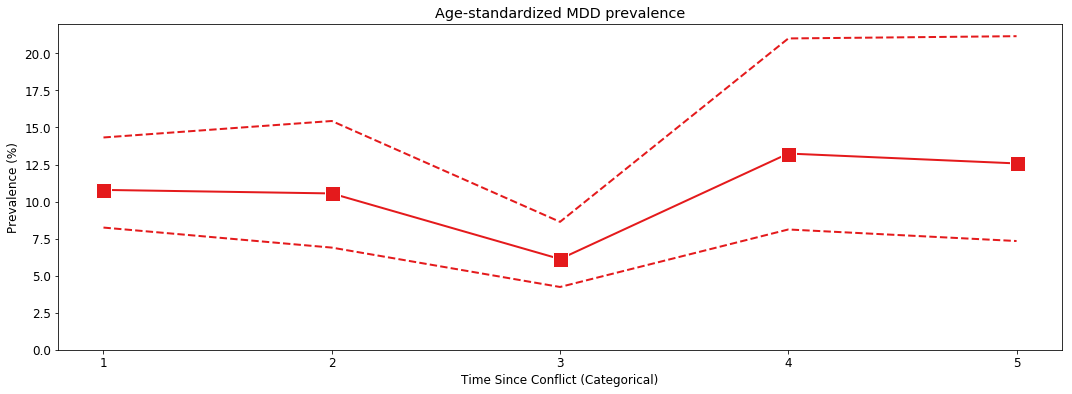

In [47]:
plt.plot(range(5), df['mean'], 's-', color=dismod_mr.plot.colors[0], linewidth=2, ms=15, mec='w')
plt.plot(range(5), df['2.5%'], '--', color=dismod_mr.plot.colors[0], linewidth=2, ms=15, mec='w')
plt.plot(range(5), df['97.5%'], '--', color=dismod_mr.plot.colors[0], linewidth=2, ms=15, mec='w')
axis(ymin=0)
title('Age-standardized MDD prevalence')
ylabel('Prevalence (%)')
xlabel('Time Since Conflict (Categorical)')
xticks([0,1,2,3,4],[1,2,3,4,5])
savefig('mdd_conflict_time.png');

In [48]:
s = stats(dm.vars['p']['p_pred'])

tt = dm.vars['p']['data']
tt['mean'] = s['mean']*100
tt['lb'] = s['95% HPD interval'][0]*100
tt['ub'] = s['95% HPD interval'][1]*100

tt = tt.query('area == "all"').filter(['data_type', 'age_start', 'age_end', 'mean', 'lb', 'ub'])

np.round(tt, 1)

,data_type,age_start,age_end,mean,lb,ub
141,p,0,10,0.3,0.0,0.9
142,p,10,20,5.0,0.1,11.8
143,p,20,30,11.6,0.9,26.3
144,p,30,40,14.0,0.5,33.1
145,p,40,50,13.5,0.6,32.9
146,p,50,60,14.5,0.1,38.8
147,p,60,70,20.2,0.1,53.3
148,p,70,80,27.7,0.9,66.9


In [49]:
# over-dispersion parameter

stats(dm.vars['p']['eta'])

{'95% HPD interval': array([ 0.70813312,  1.20322193]),
 'mean': 0.95511792746148416,
 'n': 1000,
 'standard deviation': 0.12882016866482118}